# Predicting News Popularity using FeedForward Neural Networks

_Author_: Utkarsha Khadke

_Date_  : March 30, 2018 

## Tutorial Introduction

In today's world, there is profusion of user generated content due to the rise of various social media platforms. Contributors and opinionated readers cause a lot of stir as a reaction to the news articles that are published online. This has led to a surge in the research studies related to the popularity of news article based on its topic, content and the sentiments it contains.

In this tutorial, we will learn how we can use deep neural networks to train a large dataset of news articles and predict whether the new news item will become popular on social media or not. These news items are collected from well-known aggregators such as Google News and Yahoo! News and their respective social feedback on multiple platforms such as Facebook, LinkedIn and Google+. The data collected is of a duration of 8 months ranging between November 2015 and July 2016. It consists of around 100,000 news items on topics such as economy, Obama, palestine and microsoft.

The data is obtained from  https://archive.ics.uci.edu/ml/datasets/News+Popularity+in+Multiple+Social+Media+Platforms# . You may visit this link for more information on how the data is collected.

## Importing Libraries

In [451]:
import re
import csv
import string
import sklearn
import random
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, KFold
import nltk

In [452]:
# Importing the keras libraries
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier

In [453]:
#Setting a random seed
random.seed(42) #cause it is the answer to the Ultimate Question of Life, the Universe, and Everything
                #Reference: The Hitchhiker's Guide to the Galaxy by Douglas Adams

## Importing the dataset

Here, we import the dataset from a CSV file, store it in a pandas dataframe and convert the columns into proper data types.

In [454]:
#Defining the file path 
news_filepath = "./News_Final.csv"

#Loading the contents of CSV in memory          
news_dataset = pd.read_csv(news_filepath)

#Resetting the index
news_dataset = news_dataset.reset_index(drop = True)

#Changing data types
news_dataset[['IDLink']] = news_dataset[['IDLink']].astype('int64')

#Subsetting the news dataset
news_dataset = news_dataset.sample(n=1500) #news_dataset.iloc[random.sample(news_dataset.index, 1000)]


Note: As a result of limitation of my laptop configuration, I have limited the input data to contain 1500 news articles. If required, you may directly pass the processed_ds dataset to the create_feature_matrix function in the future.

## Dataset Preview

In [455]:
news_dataset.head()

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn
61679,41616,Malaysia Economy Is Sustainable At The Core - ...,KUALA LUMPUR -- Prime Minister Datuk Seri Naji...,malaysiandigest.com,economy,2016-04-12 10:09:18,0.041667,0.090924,0,2,0
37435,77102,What Obama's Cybersecurity Strategy Leaves Out,What Obama's Cybersecurity Strategy Leaves Out...,MIT Technology Review,obama,2016-02-09 22:45:32,-0.051031,0.022097,73,3,48
66084,44530,Mitsubishi Motors admits manipulating fuel eco...,Mitsubishi Motors Corp admitted to manipulatin...,Channel NewsAsia,economy,2016-04-23 03:33:00,-0.034722,0.164685,-1,0,0
55119,36327,WonderCon expected to do wonders for Los Angel...,A hulking $36 million is expected to flow thro...,LA Daily News,economy,2016-03-26 03:28:51,0.041667,-0.026064,12,2,2
15026,9730,Azerbaijan's economy increases,The non-oil sector of the economy increased by...,Trend News Agency,economy,2015-12-16 15:58:18,0.000000,-0.102062,0,0,0


The Data Dictionary of this dataset is as follows:
1. IDLink (integer): Unique identifier of news items
2. Title (string): Title of the news item according to the official media sources
3. Headline (string): Headline of the news item according to the official media sources
4. Source (string): Original news outlet that published the news item
5. Topic (string): Query topic used to obtain the items in the official media sources
6. PublishDate (timestamp): Date and time of the news items' publication
7. SentimentTitle (numeric): Sentiment score of the text in the news items' title
8. SentimentHeadline (numeric): Sentiment score of the text in the news items' headline
9. Facebook (numeric): News items' popularity: number of times article is shared on Facebook
10. GooglePlus (numeric): News items' popularity: number of times article is shared on Facebook Google+
11. LinkedIn (numeric): News items' popularity: number of times article is shared on Facebook LinkedIn

For the last 3 columns, value -1 indicates data for that news item for the corresponding social media platform could not be collected, value 0 indicates no shares and a non-zero positive value indicates number of shares.

## Definition of Popularity

In our dataset, we will define the definition of popularity to be a summation of total number of shares on all the three social media platforms: Facebook, LinkedIn and Google+. After that, we will plot a density plot of popularity distribution to determine an arbitrary and learned point of threshold which will help us get a binary value for whether a news item becomes popular or not.

Let us define a function to perform the summation and apply it on each row.

In [456]:
# Creating a function to count Total number of times a news article is shared
def total_popularity(row):
    total = 0
    if row['Facebook'] > 0:
        total += row['Facebook'] 
    if row['LinkedIn'] > 0:
        total += row['LinkedIn']         
    if row['GooglePlus'] > 0:
        total += row['GooglePlus']  
    return total

#Calling the function on every row to determine Total Popularity
news_dataset['TotalPopularity'] = news_dataset.apply(lambda row: total_popularity(row), axis = 1)

We will now plot a graph of popularity density to identify the perfect arbitary breakpoint for classifying binary popularity for an article. 

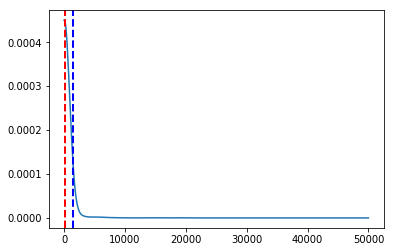

In [457]:
#Reference: https://stackoverflow.com/questions/4150171/how-to-create-a-density-plot-in-matplotlib 
density = gaussian_kde(news_dataset['TotalPopularity'])
xs = np.linspace(0,50000,400)
density.covariance_factor = lambda : 1
density._compute_covariance()
plt.plot(xs,density(xs))
plt.axvline(news_dataset['TotalPopularity'].mean(), color='r', linestyle='dashed', linewidth=2)
plt.axvline(1400, color='b', linestyle='dashed', linewidth=2)
plt.show()

From the graph above, we can see that the mean of total popularity is almost zero. Also, a majority of the news articles have total popularity less than 1400. News articles with popularity higher than that are very less in number. Therefore, we can infer that a lot of the articles have not been shared on either of Facebook, LinkedIn or GooglePlus. 

Let us consider the measure of popularity to be zero if it is not shared at all and one if shared at least once on Facebook, LinkedIn and GooglePlus.

We will write a function for binary classification based on the learned classifying valuee and apply it on every row to create the target variable 'Popular' (1 if popular, 0 otherwise).

1120


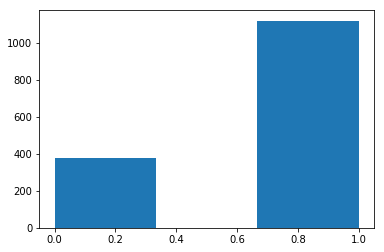

In [458]:
#Creating a function to add column 'Popularity' based on values from column 'TotalPopularity'
def add_popularity(row):
    if row['TotalPopularity'] > 0:
        return 1
    else:
        return 0
    
news_dataset['Popular'] = news_dataset.apply(lambda row: add_popularity(row), axis = 1)
print(len(news_dataset.loc[news_dataset['Popular'] > 0]))

# Plotting a histogram of Popularity
plt.hist(news_dataset['Popular'], bins = 3 )
plt.show()

Through this histogram we see that almost 75% of the news articles are popular. Therefore, if we were to classify all the news items to be popular, we would get an accuracy score of around 75% which means, we would need a model that gives us more accuracy than this. 

## Creating a Document Term Matrix

Document Term Matrix consists of all the unique words in the corpus, in this case, the news headline and the count or frequency of that word in each document. It will result in a sparse matrix with rows equal to those of original data and columns with unique words.

We will first write a function to process every news headline to create a list of valuable words in the headline by removing twitter handles, URLs, tagged words, strage characters, punctuations, stop words and lemmatizing the remaining words. 

### Function to process text

In [459]:
def process(text, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    """ Normalizes case and handles punctuation
    Inputs:
        text: str: raw text
        lemmatizer: an instance of a class implementing the lemmatize() method
                    (the default argument is of type nltk.stem.wordnet.WordNetLemmatizer)
    Outputs:
        list(str): tokenized text
    """
    
    #Converting to lower case
    text = str(text).lower()
    
    #Removing handles of form '@trump'
    text = re.sub(r'@([A-Za-z0-9_]+)', '', text)
    
    #Removing URL of form 'http...'
    text = re.sub(r'http(.[^ ]+)', '', text)
    
    #Removing tagged words
    text = re.sub(r'(<.+>)+', '', text)
    
    #Removing strange characters like â€™
    include = set(string.printable)
    text = list(filter(lambda x: x in include, text))
    text = ''.join(text)
    
    #Removing punctuations    
    exclude = set(string.punctuation)
    exclude = exclude - set("\'")
    text = text.replace("\'s","")
    text = text.replace("\'","")    
    for e in exclude:
        text = text.replace(e, " ")
    
    #Remove words less than 3 in length
    text = re.sub(r'\b\w{1,3}\b', '', text)
    
    #Initializing the result
    result = []
    
    ##lammetizing
    tokenized = nltk.word_tokenize(text)
    
    #Reference: Homework 3: text_classification.ipynb
    for token in tokenized:
        string_token = str(token)
        try:
            result.append(lemmatizer.lemmatize(string_token))
        except:
            continue
    
    #Getting NLTK stop words:
    stopwords=nltk.corpus.stopwords.words('english')
    modified_stopwords = [i.replace("\'", "") for i in stopwords]
    
    #Appending modified stop words list with some more words of no significance 
    total_stopwords = modified_stopwords + ['next', 'break', 'else', 'terms', 'while']
    
    #Removing the stop words
    result = [item for item in result if item not in total_stopwords] #result - total_stopwords
    
    return result


An example of calling the above function is as follows:

In [460]:
text = 'The bond market is booming again, @ohholybutt a sign of investorsâ€™ faith in the resilience of the U.S. economy. while http://www.imemc.org, U.S. bond sales by companies with good credit ratings hit $103 billion in October, '
print(process(text))

['bond', 'market', 'booming', 'sign', 'investor', 'faith', 'resilience', 'economy', 'bond', 'sale', 'company', 'good', 'credit', 'rating', 'billion', 'october']


We will now write a function to process the entire dataset's headline column to be replaced by lists of relevant words.

In [461]:
def process_headline(df, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    """ process all text in the dataframe using process_text() function.
        #Reference: Homework 3: text_classification.ipynb
    Inputs
        df: pd.DataFrame: dataframe containing a column 'text' loaded from the CSV file
        lemmatizer: an instance of a class implementing the lemmatize() method
                    (the default argument is of type nltk.stem.wordnet.WordNetLemmatizer)
    Outputs
        pd.DataFrame: dataframe in which the values of headline column have been changed from str to list(str),
                        the output from process() function. Other columns remain unaffected.
    """
    for i, row in df.iterrows():
        df.set_value(i,'Headline', process(row['Headline']))
    return df

Let us now run the above function on our dataset to update the News Headline column and store it in a new dataframe.

In [462]:
processed_ds = process_headline(news_dataset)

## Creating the feature matrix

We now write a function to create the feature matrix by segregating all the unique words from the Headline column into their own respective columns and storing the frequency value for those terms in the corresponding rows. We also add other input features from the original matrix such as the Topic, SentimentTitle, SentimentHeadline and the target variable 'Popular'.

In [463]:
def create_feature_matrix(processed_ds): 
    """ creates the feature matrix using the processed headline text
    Inputs:
        news: pd.DataFrame: processed news dataset, containing the column 'Headline'
        #rare_words: list(str): one of the outputs of get_feature_and_rare_words() function
    Outputs:
        feature_matrix: matrix of unique words and their frequency for each row
                                we need this to tranform test news in the same way as train news
    """
    
    #Getting unique words from the Headline column
    #Reference: https://stackoverflow.com/questions/3724551/python-uniqueness-for-list-of-lists
    total_words = [x for y in processed_ds['Headline'] for x in y]
    total_unique_words = set(total_words)
    
    #Adding additional feature column names
    total_features = list(total_unique_words) + ['Topic',
        'SentimentTitle', 'SentimentHeadline', 'Popular']
    
    #Initializing the feature matrix
    feature_matrix = pd.DataFrame(columns = total_features)
    
    print("Final Columns: ", feature_matrix.columns)
    
    #Reference: Practical Data science: Homework 3: text classification
    #Creating string corpus
    for i, row in processed_ds.iterrows():
        
        #counting the frequency of words in the headline
        word_freq = Counter(row['Headline'])
              
        #Storing the corresponding frequencies for each row
        row_list = []
        row_list = [0]*len(total_unique_words)
        new_row_df = pd.DataFrame([row_list],columns=total_unique_words)                
        for word in word_freq:
            new_row_df.loc[0,word] = word_freq[word]
                
        #Adding other feature columns to feature matrix:
        #Topic
        new_row_df.loc[0,'Topic'] = row['Topic']
        
        #SentimentTitle
        new_row_df.loc[0,'SentimentTitle'] = row['SentimentTitle']

        #SentimentHeadline
        new_row_df.loc[0,'SentimentHeadline'] = row['SentimentHeadline']
        
        #Popularity = target variable
        new_row_df.loc[0,'Popular'] = row['Popular']
        
        #Appending the row to the final matrix
        feature_matrix = pd.concat([feature_matrix, new_row_df], ignore_index= True )    
    
    #Returning values
    return feature_matrix


We now call the above function on our input data and store the result in a new dataframe. 

In [464]:
#Subsetting the dataframe and passing it to create the final feature matrix
input_matrix = create_feature_matrix(processed_ds)
print("Dimensions of input matrix", input_matrix.ndim)

Final Columns:  Index(['luxury', 'indonesia', 'employee', '2025', 'larijani', 'urging',
       'encouraged', 'brash', 'ieee', 'fifty',
       ...
       'vietnamese', 'amosun', 'desperate', 'error', 'hulking', 'every',
       'Topic', 'SentimentTitle', 'SentimentHeadline', 'Popular'],
      dtype='object', length=5920)
Dimensions of input matrix 2


## Input matrix preview

In [466]:
input_matrix.head()

,luxury,indonesia,employee,2025,larijani,urging,encouraged,brash,ieee,fifty,...,vietnamese,amosun,desperate,error,hulking,every,Topic,SentimentTitle,SentimentHeadline,Popular
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,economy,0.041667,0.090924,1.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,obama,-0.051031,0.022097,1.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,economy,-0.034722,0.164685,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,economy,0.041667,-0.026064,1.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,economy,0.000000,-0.102062,0.0


# FeedForward Neural Networks

For our dataset, we have a vast amount of input variables and a single output variable. Therefore, we need a model with a high computational predictive power for our prediction. 

Enter **Neural Networks**!

The simplest definition of a neural network, more properly referred to as an 'artificial' neural network (ANN), is provided by the inventor of one of the first neurocomputers, Dr. Robert Hecht-Nielsen. He defines a neural network as:
    _"...a computing system made up of a number of simple, highly interconnected processing elements, which process information by their dynamic state response to external inputs."_ [1]

It is a computer system modeled on our human brain and nervous system. 
    
There are different types of neural networks such as Recurrent Neural networks, convolutional neural networks,etc. In our case, we will use a **Feedforward neural network**. Feedforward neural networks are great for learning a pattern between a set of inputs and outputs with high computational power. According to Wiki, a feedforward neural network is an artificial neural network wherein connections between the units do not form a cycle. 

In our model, we have the input layer, one hidden layer and an output as shown below.

<img src="./ffnn.png" alt="NewsDataset Neural Network" title="FeedForward Neural Network">

Internally, at every step, our model takes a weighted sum of the inputs at that step, applies an activation function on it and gives a specified number of outputs that are equivalent to the number of inputs the next layer takes. We also define a loss function that helps to optimize our model by decreasing the loss. In our case it is binary_crossentropy as our output variable is a binary classifier output. For activation, we use the sigmoid function in order to capture the linear as well as non-linear property of our functions.

## Creating the train and test set

Let us perform random sampling of the data to define 70% of it to be training set and the remaining 30% to be the test set. We also separate the target variable 'Popular' in a 1D array from the rest of the input variables for both, the train and test set. The input variable Topic and the target variable 'Popular' needs to be converted into categorial types.

In [467]:
#Converting the topic variable to categorical type
#Reference:https://stackoverflow.com/questions/32011359/convert-categorical-data-in-pandas-dataframe
input_matrix['Topic'] = input_matrix['Topic'].astype('category')
cat_columns = input_matrix.select_dtypes(['category']).columns

#Converting the string category to numeric code for each
input_matrix[cat_columns] = input_matrix[cat_columns].apply(lambda x : x.cat.codes)

#Converting the target variable to categorical type
input_matrix['Popular'] = to_categorical(input_matrix['Popular'])

#Separating the input variables from the target variable
X = input_matrix.drop(['Popular'], axis = 1)
Y = input_matrix['Popular']

#Randomly splitting the data into train(70%) and test(30%) sets
training_set_x, test_set_x, training_set_y, test_set_y = train_test_split(X, Y, test_size = 0.3)


## Training the model

We first initialize the model as Sequential which means it is a linear stack of layers. 

In [468]:
# Initializing the Neural Network
model = Sequential()

We then add the input layer specifying the shape of the input data same as our input matrix, give the ouputs to be 10 and specify the activation function to be a sigmoid to learn both linear as well as non-linear functions in the data. 

In [469]:
#Adding the input layer
model.add(Dense(units = 15, input_shape=(training_set_x.shape[1],), activation='sigmoid'))

We add a hidden layer after the input layer.

In [470]:
#Adding a hidden layer
model.add(Dense(units = 10, input_dim=15, activation='sigmoid'))

Then, we add the output layer by defining only 1 output and sigmoid to be the activation function.

In [471]:
#Adding the output layer
model.add(Dense(units = 1, activation='sigmoid'))

Then, we define the optimizer by specifying the learning rate which is the ability of the neural network to abandon old beliefs for new ones, that is, how quickly it learns. The rest of the parameters are recommended to be kept the same.

In [472]:
#Creating an optimizer
rmsprop = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

We then compile our model using the above optimizer, define the loss function that is adapted for binary output and define the metric for measurement to be accuracy. 

In [473]:
#Compiling the RNN
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

Finally, we fit the model on our training dataset by mentioning the number of epochs to train the model and verbosity mode to be silent (0). The batch size which is the number of samples per gradient update is kept at a default of 32.

In [474]:
# Fitting the RNN to training set
model.fit(training_set_x, training_set_y, epochs=40, verbose=0)

## Predicting outcome using the trained model

We now call the predict function on our trained model on the train as well as test data. It returns a numpy array of predictions between 0 and 1. We will define our threshold to be 0.5, meaning that if the value is less 0.5, the popularity is zero, one otherwise.

In [475]:
#Predicting the outcome on the training set and alloting the appropriate class
y_train_pred = model.predict(training_set_x)
y_train_class_pred = y_train_pred > 0.5
y_train_class_pred = y_train_class_pred.astype(int)

#Predicting the outcome on the test set and alloting the appropriate class
y_test_pred = model.predict(test_set_x)
y_test_class_pred = y_test_pred > 0.5
y_test_class_pred = y_test_class_pred.astype(int)

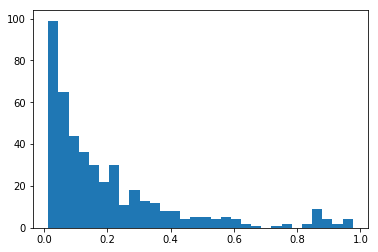

In [476]:
# Plotting a histogram distribution of Predicted Popularity on test set
plt.hist(y_test_pred, bins = 30 )
plt.show()

## Accuracy check

According to wiki, accuracy of a classifier measures the fraction of all data points that are correctly classified by it; it is the ratio of the number of correct classifications to the total number of (correct or incorrect) classifications. We will now calculate the same for our predictions and guage how accurate they are, using sklearn library's accuracy_score method for our train as well as test data.

In [477]:
# Reference: https://github.com/neelabhpant/Deep-Learning-in-Python/blob/master/Logistic_Regression_Keras.ipynb
print("The training accuracy score is {:0.3f}".format(accuracy_score(training_set_y, y_train_class_pred)))
print("The testing accuracy score is {:0.3f}".format(accuracy_score(test_set_y, y_test_class_pred)))

The training accuracy score is 0.990
The testing accuracy score is 0.727


We see that our training accuracy is pretty high while our test accuracy is just okay. This is because, as we saw earlier, if we were to classify all the news items to be popular, we would still get around 75% accuracy. In that sense, our model is not really doing a good job and we would need to find ways to either tune it more, find more appropriate features or use another model.

## Confusion Matrix

In [478]:
#Function to create the confusion matrix 
def create_confusion_matrix(true_y, y_pred, categories=[0, 1]):
    
    #Converting to 1D lists
    true_y = list(true_y)    
    y_pred = list(y_pred.flatten())

    #Confusion matrix
    conmat = confusion_matrix(true_y, y_pred)
    
    #Defining the categories
    pred_categories = ["Predicted "+ c for c in categories]
    
    #Creating the CM dataframe
    cm_df = pd.DataFrame(conmat, index=categories, columns=pred_categories)
    
    return cm_df

#Printing the confusion matrix
print("Training Data Confusion Matrix :\n\n",create_confusion_matrix(training_set_y, y_train_class_pred, ["Not Popular", "Popular"]))
print("------------------------------------------------")
print("Testing Data Confusion Matrix :\n\n",create_confusion_matrix(test_set_y, y_test_class_pred, ["Not Popular", "Popular"]))

Training Data Confusion Matrix :

              Predicted Not Popular  Predicted Popular
Not Popular                    789                  0
Popular                         10                251
------------------------------------------------
Testing Data Confusion Matrix :

              Predicted Not Popular  Predicted Popular
Not Popular                    307                 24
Popular                         99                 20


## Tuning the model: K-fold cross validation

We can probably improve this accuracy by tuning our model using K-fold cross validation.

In [479]:
#Function to build the neural network so that it can be run over and over again
def build_neuralnet_model():
    nnmodel = Sequential()
    nnmodel.add(Dense(15, input_shape=(training_set_x.shape[1],), activation='sigmoid'))
    nnmodel.add(Dense(units = 10, input_dim=15, activation='sigmoid'))
    nnmodel.add(Dense(1, activation='sigmoid'))
    nnmodel.compile(optimizer=rmsprop,
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
    return nnmodel

#Reference: https://github.com/neelabhpant/Deep-Learning-in-Python/blob/master/Logistic_Regression_Keras.ipynb
nnmodel = KerasClassifier(build_fn=build_neuralnet_model,
                        epochs=40,
                        verbose=0)

#Running the Kfold cross validation on the neural net model created
cross_val = KFold(5, shuffle=True)
scores = cross_val_score(nnmodel, training_set_x, training_set_y, cv=cross_val)

print("The cross validation accuracy is {:0.4f} ± {:0.4f}".format(scores.mean(), scores.std()))

The cross validation accuracy is 0.7257 ± 0.0149


Since the cross validation accuracy is more or less the same as the Accuracy we got previously, we can say that our model is sufficiently tuned even after shuffling our data through various folds of cross-valdiation.

## Possible further research areas

In order to increase our model performance, we can expand our research in the following ways:
1. Instead of using a Document Term Matrix, we can possibly use a TFIDF matrix as input features.
2. Instead of converting Popularity to a binary variable, we can predict the actual measure of popularity, that is, the total number of shares. 

But wait... what if the ordering of data mattered? If we order our news items according to their Publish Dates, the popularity of a previously published news item may affect the popularity of the newly published news article on the same topic, that is, economy and having similar kind of words along with their frequency.

As a result, by ordering the input data by Publish Date and making it **sequential**, we can possibly use Recurrent Neural Networks to use previous hidden state for a **particular topic** and predict the popularity based on similar words and sentiments, to predict the popularity for subsequent news articles.

## References

1. http://pages.cs.wisc.edu/~bolo/shipyard/neural/local.html
2. https://keras.io/optimizers/
2. https://keras.io/getting-started/sequential-model-guide/
3. https://arxiv.org/pdf/1801.07055.pdf
4. https://github.com/neelabhpant/Deep-Learning-in-Python/blob/master/Logistic_Regression_Keras.ipynb
5. https://github.com/kimanalytics/Recurrent-Neural-Network-to-Predict-Stock-Prices/blob/master/Recurrent%20Neural%20Network%20to%20Predict%20Tesla%20Stock%20Prices.ipynb
6. https://github.com/Kulbear/stock-prediction/blob/master/data-preparation.ipynb